In [1]:
import numpy as np
from netCDF4 import Dataset
import datetime
import glob
import os
import matplotlib.pyplot as plt
import cartopy
from matplotlib import gridspec
from regrid import regrid
import itertools
import cartopy.crs as ccrs
import tqdm
from scipy.stats import linregress
from pyproj import Proj, Transformer
from scipy.spatial.kdtree import KDTree
import warnings
warnings.filterwarnings("ignore")
np.float = float

/opt/anaconda3/envs/phd/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/var/folders/_1/fh2vf5m57871c546k_sf7xr80000gn/T/ipykernel_1508/3285376567.py:15: DeprecationWarning: Please use `KDTree` from the `scipy.spatial` namespace, the `scipy.spatial.kdtree` namespace is deprecated.
  from scipy.spatial.kdtree import KDTree


In [2]:
def lonlat_to_xy(coords_1, coords_2, hemisphere, inverse=False):

    """Converts between longitude/latitude and EASE xy coordinates.
 
    Args:
        lon (float): WGS84 longitude
        lat (float): WGS84 latitude
        hemisphere (string): 'n' or 's'
        inverse (bool): if true, converts xy to lon/lat
 
    Returns:
        tuple: pair of xy or lon/lat values
    """

    EASE_Proj = {'n': 'EPSG:3408',
                 's': 'EPGS:3409'}
    
    WGS_Proj = 'EPSG:4326'
    
    for coords in [coords_1, coords_2]: assert isinstance(coords,(np.ndarray,list))

    if inverse == False: # lonlat to xy
        
        lon, lat = coords_1, coords_2
        
        transformer = Transformer.from_crs(WGS_Proj, EASE_Proj[hemisphere])
        
        x, y = transformer.transform(lat, lon)
        
        return (x, y)

    else: # xy to lonlat
        
        x, y = coords_1, coords_2
        
        transformer = Transformer.from_crs(EASE_Proj[hemisphere], WGS_Proj)
        
        lat, lon = transformer.transform(x, y)
        
        return (lon, lat)

In [3]:
# load ease lons,lats:
foam_lats = np.load('/Users/carmennab/Dropbox/alpha_retracker/data/auxiliary/lat_25km_cent.npy')
foam_lons = np.load('/Users/carmennab/Dropbox/alpha_retracker/data/auxiliary/lon_25km_cent.npy')

# convert into x,y:
foam_x, foam_y = lonlat_to_xy(foam_lons,foam_lats,hemisphere='n')

# create KDTree to find EASE grid cell closest to buoy:
tree = KDTree(list(zip(foam_x.ravel(),foam_y.ravel())))

In [4]:
datapath = '/Users/carmennab/Dropbox/met_office/data/CTRL_vs_product/'

base = 'UCL_BASELINE_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA1_r243541_dcarneir'
unc = 'UCL_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA1_NEW_OBERR_r243541_dcarneir'
### alpha
nine = 'UCL_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA09_r243541_dcarneir'
six = 'UCL_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA06_r243541_dcarneir'
### retracker
larm = 'UCL_SIT_ASSIM_CS2_BRISTOL_SNFOAM_ALPHA1_r243541_dcarneir'
cpom = 'UCL_SIT_ASSIM_CS2_CPOM_SNFOAM_ALPHA1_r243541_dcarneir'
### snow
smlg = 'UCL_SIT_ASSIM_CS2_AWI_SNLG_ALPHA1_r243541_dcarneir'
awi = 'UCL_SIT_ASSIM_CS2_AWI_SNAWI_ALPHA1_r243541_dcarneir'

sits = [base,nine,six,larm,cpom,smlg,awi,unc]
names = ['BASE','\u03B1_0.9', '\u03B1_0.6','FB_LARM','FB_CPOM','SN_SMLG','SN_AWI','UNC']

In [12]:
all_diffs = {} ; means = {} ; stdevs = []

for name, sit in zip(names, sits):
    print(name)
    diffs = [] ; product = []
    folder = f'{datapath}matchups_{sit}/'
    for file in os.listdir(folder):
        inds_ct = {} ; inds_pr = {}
        ctrl_grid = np.full((foam_lats.shape[0],foam_lats.shape[1]),np.nan)
        product_grid = np.full((foam_lats.shape[0],foam_lats.shape[1]),np.nan)
        
        data = Dataset(folder+file)
        ctrl = np.array(data['SIT_Hx'])[:,0]
        product = np.array(data['SIT_OBS'])[:,0]
        ctrl[ctrl>100] = np.nan
        product[np.isnan(ctrl)] = np.nan
        
        lons = np.array(data['LONGITUDE'])
        lats = np.array(data['LATITUDE'])
        
        # convert lon,lat into x,y:
        x,y = lonlat_to_xy(lons,lats,hemisphere='n') 

        for x,y,ct,pr in zip(x,y,ctrl,product):

            dist, ind = tree.query([x,y])

            ind2d = np.unravel_index(ind, (foam_lats.shape[0],foam_lats.shape[1]))

            if ind2d in inds_ct.keys():
                inds_ct[ind2d].append(ct)
                inds_pr[ind2d].append(pr)
            else:   
                inds_ct[ind2d] = [ct]
                inds_pr[ind2d] = [pr]

        for key in inds_ct.keys():
            ctrl_grid[key[0],key[1]]=np.nanmean(inds_ct[key])
            product_grid[key[0],key[1]]=np.nanmean(inds_pr[key])
        
        diffs.append(product_grid - ctrl_grid)
        product.append(product_grid)
        
    diff = np.nanmean(np.array(diffs),axis=0)
    means[name] = diff
    mean_product =  np.nanmean(np.array(product),axis=0)
    stdevs.append(mean_product)
    
means['STDEV'] = np.std(stdevs,axis = 0)

BASE
α_0.9
α_0.6
FB_LARM
FB_CPOM
SN_SMLG
SN_AWI
UNC


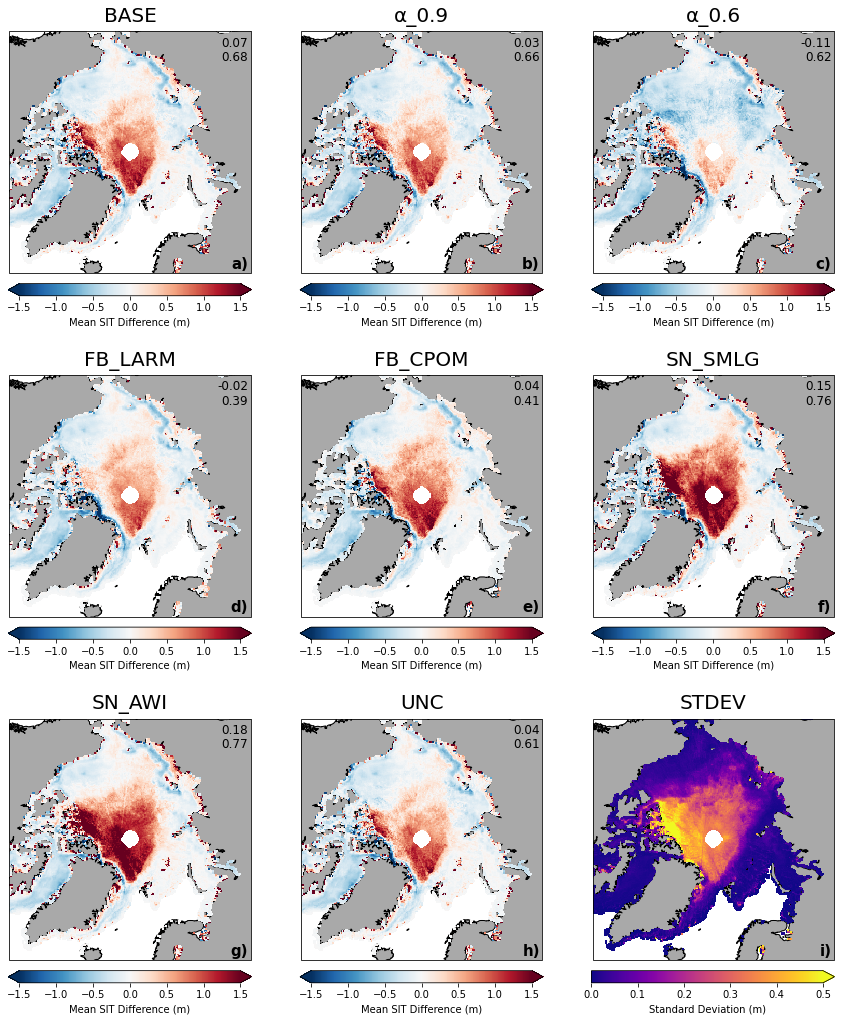

In [16]:
fig = plt.figure(figsize=(15,17.5))
spec = gridspec.GridSpec(ncols=3, nrows=3, hspace=0.3, wspace=0.15)

names = ['BASE','\u03B1_0.9', '\u03B1_0.6','FB_LARM','FB_CPOM','SN_SMLG','SN_AWI','UNC','STDEV']
nums = ['a)','b)','c)','d)','e)','f)','g)','h)','i)']

for count, name in enumerate(names):
    ax = fig.add_subplot(spec[count],projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax.coastlines()
    ax.set_title(name, fontsize=20, pad=10)  
    if count == 8:
        p_map = ax.pcolormesh(foam_lons,foam_lats,means[name][:-1,:-1],vmin=0,vmax=0.5,cmap='plasma',
                              transform=ccrs.PlateCarree()) 
        a = plt.colorbar(p_map,location="bottom",fraction=0.046, pad=0.04,extend='max') 
        a.set_label('Standard Deviation (m)',fontsize='medium')  
    else:
        p_map = ax.pcolormesh(foam_lons,foam_lats,(means[name][:-1,:-1]),cmap='RdBu_r',vmin=-1.5,vmax=1.5,
                              transform=ccrs.PlateCarree())
        ax.text(0.99, 0.94, f"{np.round(np.nanmean(means[name]),decimals=2):.2f}", fontsize=12, ha= 'right', 
                transform = ax.transAxes)    
        ax.text(0.99, 0.88, f"{np.round(np.nanstd(means[name]),decimals=2):.2f}", fontsize=12, ha= 'right', 
                transform = ax.transAxes)
        cbar = plt.colorbar(p_map,location="bottom",fraction=0.046, pad=0.04, extend = 'both') 
        cbar.set_label('Mean SIT Difference (m)',fontsize='medium')  
    ax.text(0.99, 0.02, nums[count], fontsize=15, ha= 'right', transform = ax.transAxes,fontweight='bold')
    
plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/FOAM sensitivity/main_figs/CTRL_vs_product.png',dpi=400, 
bbox_inches="tight")